In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  1 10:49:05 2024

@author: talha
"""
#%%
import cv2, math, copy
import glob
import json
import numpy as np
import os
from fmutils import fmutils as fmu
from tqdm import trange, tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from pathlib import Path
from drawing_utils import draw_body, draw_hand, draw_face

# load normalized and centered pose data
body_coco = np.load('D:/MMAI/data/MMAI/data_v3/aligned/pose/a_patient_23/body_coco.npy')
data = np.load('D:/MMAI/data/MMAI/data_v3/aligned/pose/a_patient_23/body.npy')
rh =  np.load('D:/MMAI/data/MMAI/data_v3/aligned/pose/a_patient_23/r_hand.npy')
lh =  np.load('D:/MMAI/data/MMAI/data_v3/aligned/pose/a_patient_23/l_hand.npy')
face =  np.load('D:/MMAI/data/MMAI/data_v3/aligned/pose/a_patient_23/face.npy')

# function used for normalizing the pose data
def pose_norm_cent(pose_array, H, W):
    # normalize
    pose_array[0:1,:,:,:] = pose_array[0:1,:,:,:] / W
    pose_array[1:2,:,:,:] = pose_array[1:2,:,:,:] / H
    # centralization
    pose_array[0:2,...] = pose_array[0:2,...] - 0.5
    return pose_array

# function used for denormalizing the pose data
def pose_denorm_cent(pose_array, H, W):
    # centralization
    pose_array[0:2,...] = pose_array[0:2,...] + 0.5
    # denormalize
    pose_array[0:1,:,:,:] = pose_array[0:1,:,:,:] * W
    pose_array[1:2,:,:,:] = pose_array[1:2,:,:,:] * H
    return pose_array

def norm(x):
    y = ((x - np.min(x)) / (np.max(x) - np.min(x))) * 255
    return y

def gen_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel = kernel / np.sum(kernel)
    kernel = (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))
    return kernel

def extract_patches(img, kpts, kernel_size = 128, kernel_sigma=0.3, scale=1/4):
    img_shape = img.shape # 1080 x 1920 x 3 video resolution
    pad_img = np.zeros((img_shape[0]+kernel_size*2, img_shape[1]+kernel_size*2, 3))
    pad_img[kernel_size:-kernel_size, kernel_size:-kernel_size, :] = img
    kernel = gen_kernel(kernel_size,kernel_size*kernel_sigma)
    kernel = np.expand_dims(kernel,2).repeat(3,axis=2)
    kpts = np.delete(kpts, [[3],[4]], axis=0) # we don't have neck keypoints so only remove the left rigth ears
    patches = np.zeros((15,math.ceil(scale*kernel_size),math.ceil(scale*kernel_size),3))
    for idx in range(15):
        tmp = norm(pad_img[int(kpts[idx,1]+0.5*kernel_size):int(kpts[idx,1]+1.5*kernel_size), int(kpts[idx,0]+0.5*kernel_size):int(kpts[idx,0]+1.5*kernel_size),:] * kernel)
        tmp = cv2.resize(tmp, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        patches[idx,:,:,:] = tmp
    return patches

In [ ]:
#%%

# denormalize the pose data
data = pose_denorm_cent(data, 384, 640) # (3, 44202, 25, 1)
rh = pose_denorm_cent(rh, 384, 640)
lh = pose_denorm_cent(lh, 384, 640)
face = pose_denorm_cent(face, 384, 640)
body_coco = pose_denorm_cent(body_coco, 384, 640)

# load corresponding video
cap = cv2.VideoCapture('D:/MMAI/data/tests/keypoints filtering/LANGFORD.avi')

# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")
    
i = 0
# Read until video is completed
while(cap.isOpened()):
    ret, image = cap.read()
    if ret == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # resize image to 1080 x 1920
        image = cv2.resize(image, (640, 384), interpolation = cv2.INTER_AREA)
        frame = image.copy()        
        # get H and W of the frame
        H, W, _ = frame.shape
        
        # draw the pose data
        frame = draw_body(data.squeeze()[:,i,:].T, frame) # (3, 44202, 25, 1) -> (25, 3)
        frame = draw_hand(rh.squeeze()[:,i,:].T, frame)
        frame = draw_hand(lh.squeeze()[:,i,:].T, frame)
        frame = draw_face(face.squeeze()[:,i,:].T, frame)
        
        b_coco = body_coco.squeeze()[:,i,:].T
        
        patches = extract_patches(image, b_coco) # patch dim (15, 32, 32, 3)
        
        # Display the resulting frame
        cv2.imshow('Frame', frame)
        i += 1
        # print(i)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        

    else:
        break

# When everything done, release
# the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

C:\Users\talha\AppData\Local\Temp\ipykernel_50476\1376235920.py:47: RuntimeWarning: invalid value encountered in divide
  y = ((x - np.min(x)) / (np.max(x) - np.min(x))) * 255


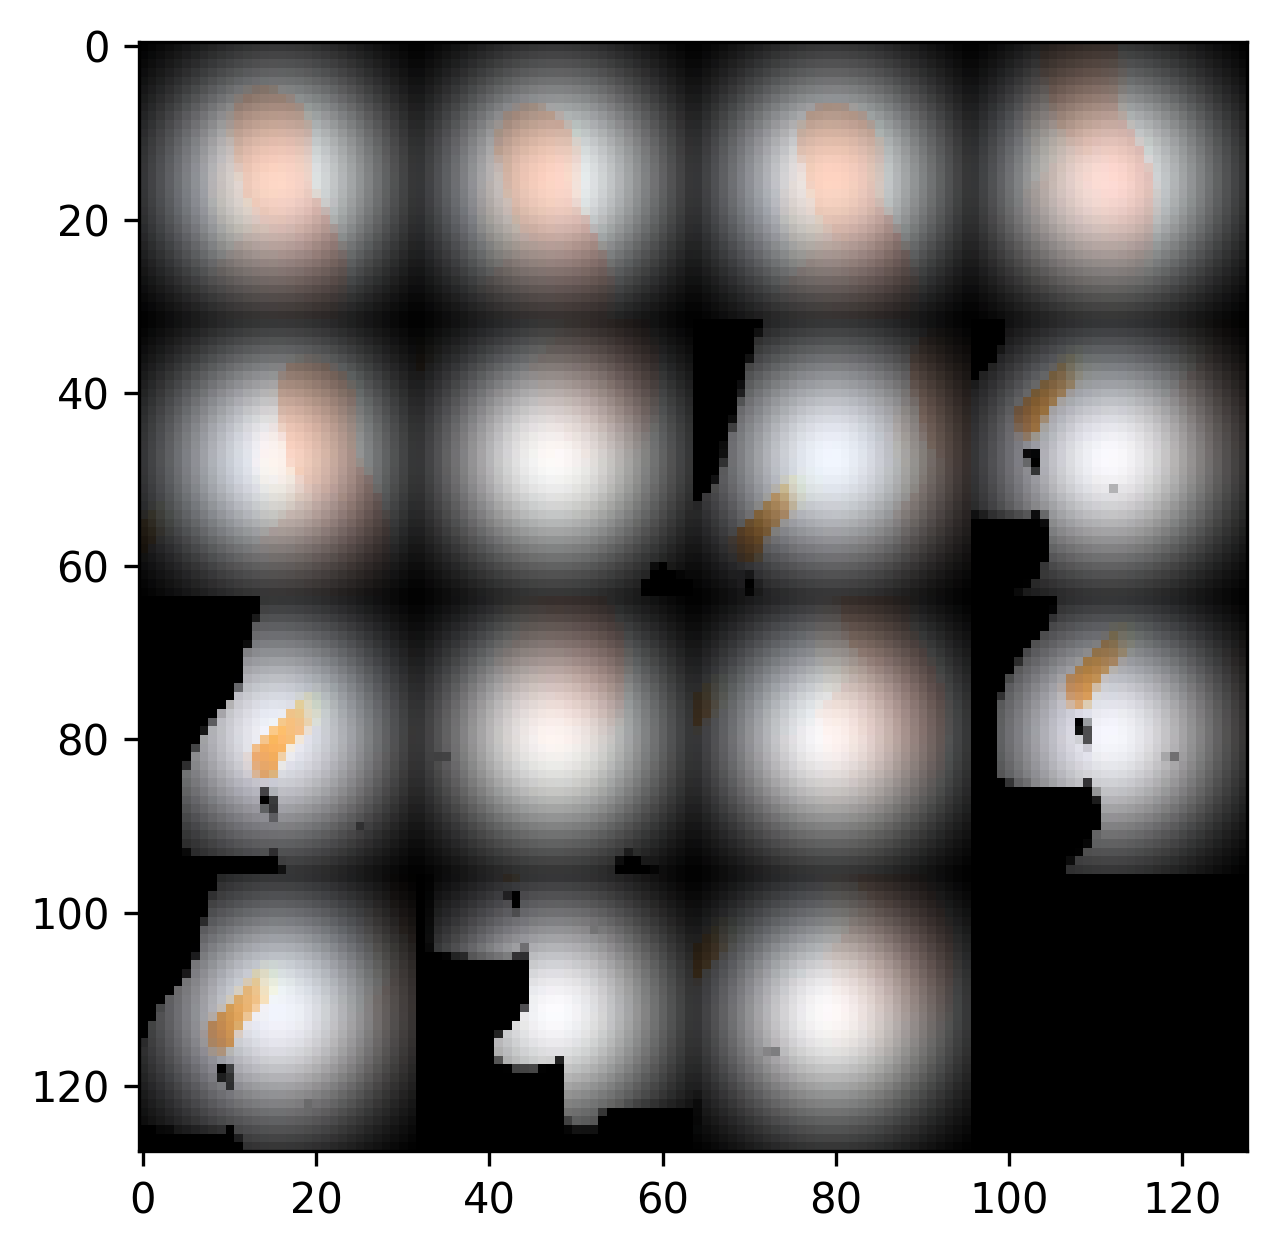

In [3]:
#%%

# plot the patches as grid using imgviz
import imgviz
import numpy as np

patches = patches.astype(np.uint8)
tile = imgviz.tile(patches)
plt.imshow(tile)

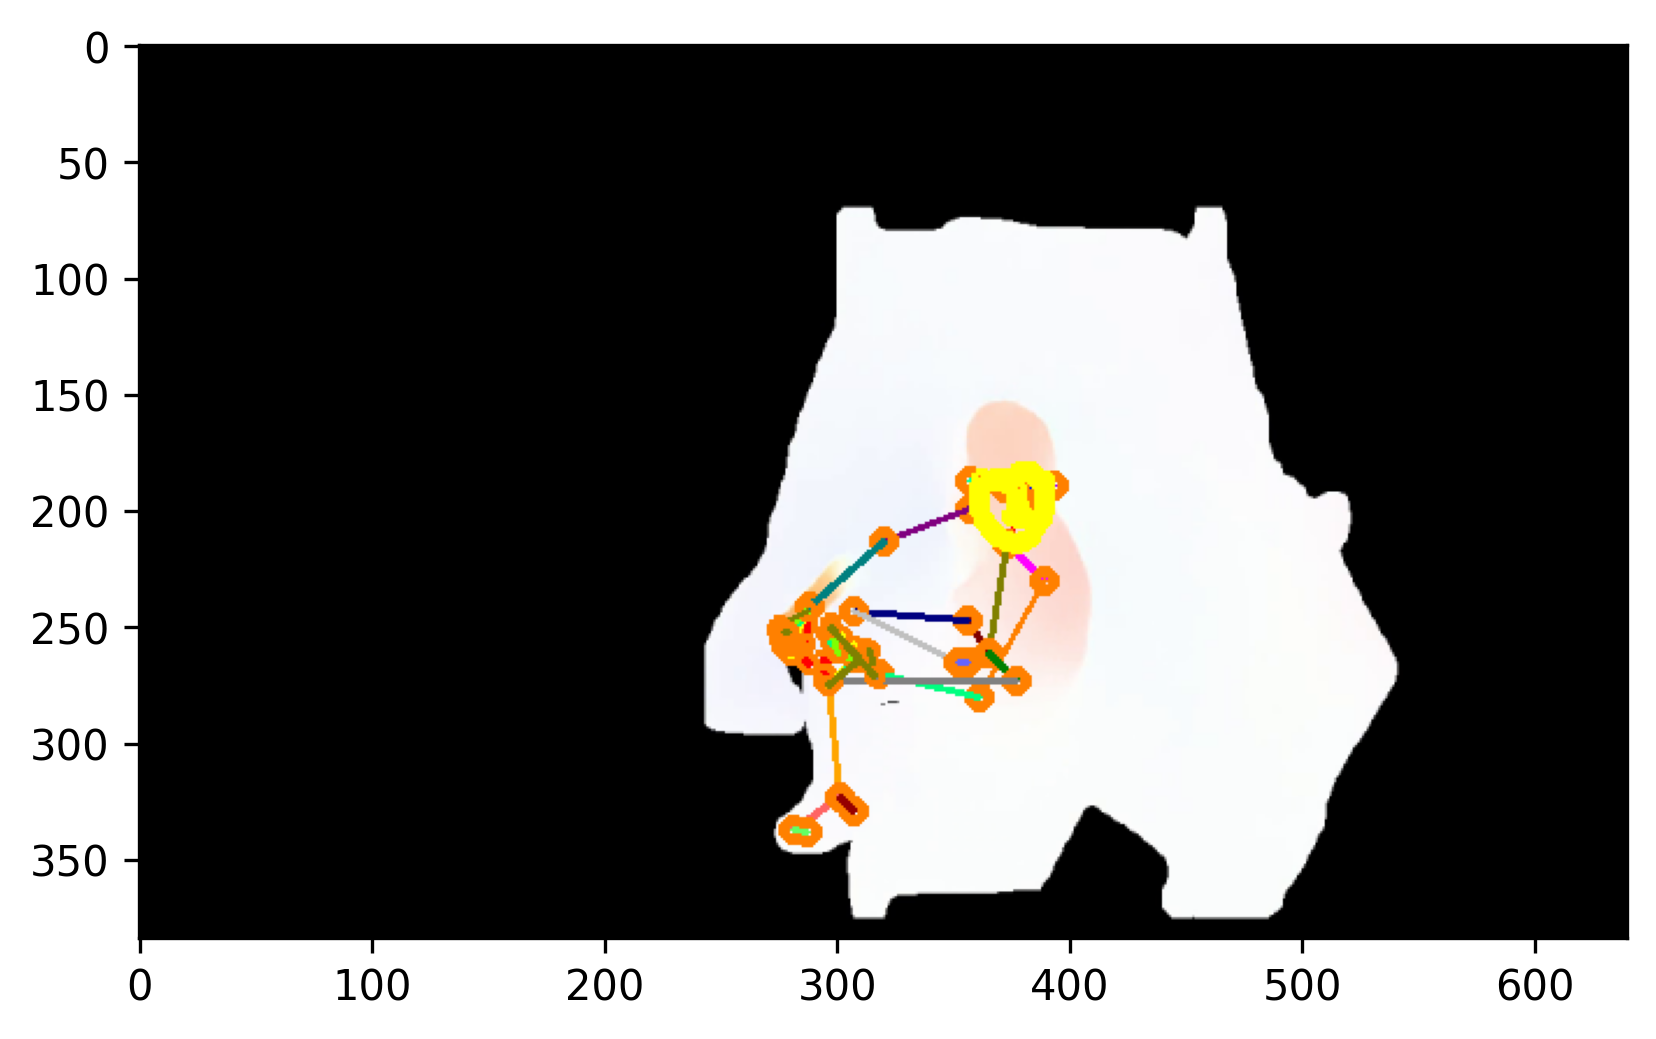

In [4]:
plt.imshow(frame)

In [8]:
# Remove keypoints 3 and 4 and reorder the remaining keypoints (left and right ears) to match the COCO order
new_order = [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Apply the new order to the b_coco array
b_coco_reordered = b_coco[new_order, :]

print(b_coco_reordered.shape)

(15, 3)
